<a href="https://colab.research.google.com/github/Amnariaz640/Pytorch-/blob/main/Box_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert CIFAR-10 Image files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [ ]:
# Train Data
train_data = datasets.CIFAR10(root='/Image_data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
# Test Data
test_data = datasets.CIFAR10(root='/Image_data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Image_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /Image_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Define the data preprocessing transformations
transform = transforms.Compose([
    transforms.RandomCrop(size=(224, 224)),          # Randomly crop the image to 224x224 and resize
    transforms.RandomHorizontalFlip(p=0.5),                 # Randomly flip the image horizontally with 50% probability
    transforms.ToTensor(),                                  # Convert the image to a PyTorch tensor and scale it to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize with mean and std for ImageNet
])

# Access a single transformed image and label
img, label = train_data[0]

In [ ]:
# Create small batch size for images .... 10
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding=1)
        # Max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
# Apply L2 regularization (weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [32]:
# Train the Data
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}")  # Should print epoch number correctly

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print("Training complete")

Starting epoch 1
Epoch [1/5], Loss: 0.7423, Accuracy: 74.02%
Starting epoch 2
Epoch [2/5], Loss: 0.6474, Accuracy: 77.43%
Starting epoch 3
Epoch [3/5], Loss: 0.5618, Accuracy: 80.30%
Starting epoch 4
Epoch [4/5], Loss: 0.4805, Accuracy: 83.01%
Starting epoch 5
Epoch [5/5], Loss: 0.4106, Accuracy: 85.56%
Training complete


In [33]:
# Testing
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 74.98%


In [34]:
# Split train_data into training and validation
from torch.utils.data import random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()

# Evaluation on the validation set
correct = 0
total = 0

with torch.no_grad():  # No gradient calculation
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 90.17%


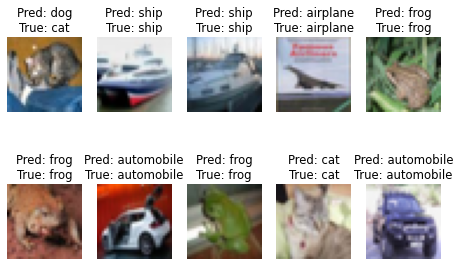

In [35]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to show images with predictions
def show_predictions(loader, model, class_names, num_images=10):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)

 # Perform predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)


    # Plot images
    plt.figure(figsize=(8, 5), dpi=70)
    for i in range(num_images):  # Show first num_images images
        plt.subplot(2, 5, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')

    plt.show()

show_predictions(test_loader, model, class_names, num_images=10)

In [36]:
torch.save(model.state_dict(), 'image_model.pth')

In [37]:
net = CNNModel()
net.load_state_dict(torch.load('image_model.pth', weights_only=True))

<All keys matched successfully>

In [66]:
new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image


image_paths = ['pic4.jfif']
images = [load_image(img) for img in image_paths]

net = CNNModel()
net.load_state_dict(torch.load('image_model.pth', map_location=torch.device('cpu'), weights_only=True))  # Load weights only
net.eval()
with torch.no_grad():
  for image in images:
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    print(f'Prediction: {class_names[predicted.item()]}')

Prediction: truck


In [58]:
!pip install opencv-python

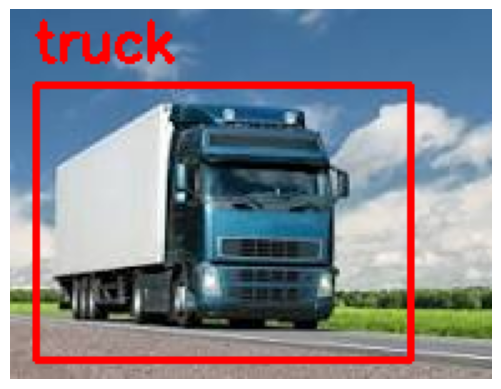

In [73]:
import cv2
import matplotlib.pyplot as plt

# Function to draw bounding boxes
def draw_bounding_boxes(image_path, predicted_class, box_coordinates):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Draw the bounding box using the updated coordinates
    cv2.rectangle(img, (box_coordinates[0], box_coordinates[1]),
                  (box_coordinates[2], box_coordinates[3]),
                  (255, 0, 0), 2)  # Blue rectangle

    # Add text for the predicted class
    cv2.putText(img, predicted_class, (box_coordinates[0], box_coordinates[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Display the image with bounding box
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Path to your image
image_path = 'pic4.jfif'

# Updated bounding box coordinates for the bird [x1, y1, x2, y2]
box_coordinates = [10, 30, 160, 140]  # Adjusted coordinates to fit the bird better

# Predicted class (e.g., 'bird')
predicted_class = 'truck'

# Draw the bounding box on the image
draw_bounding_boxes(image_path, predicted_class, box_coordinates)

In [75]:
new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image


image_paths = ['pic5.jfif']
images = [load_image(img) for img in image_paths]

net = CNNModel()
net.load_state_dict(torch.load('image_model.pth', map_location=torch.device('cpu'), weights_only=True))  # Load weights only
net.eval()
with torch.no_grad():
  for image in images:
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    print(f'Prediction: {class_names[predicted.item()]}')

Prediction: bird


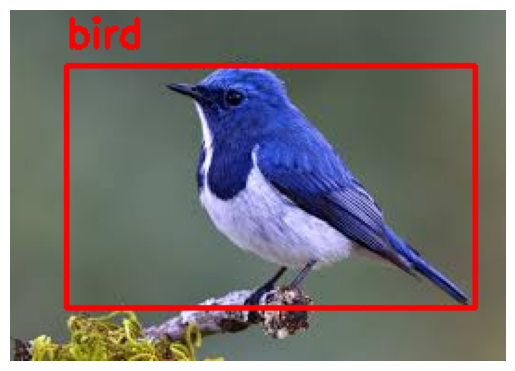

In [77]:
import cv2
import matplotlib.pyplot as plt

# Function to draw bounding boxes
def draw_bounding_boxes(image_path, predicted_class, box_coordinates):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Draw the bounding box using the updated coordinates
    cv2.rectangle(img, (box_coordinates[0], box_coordinates[1]),
                  (box_coordinates[2], box_coordinates[3]),
                  (255, 0, 0), 2)  # Blue rectangle

    # Add text for the predicted class
    cv2.putText(img, predicted_class, (box_coordinates[0], box_coordinates[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # Display the image with bounding box
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Path to your image
image_path = 'pic5.jfif'

# Updated bounding box coordinates for the bird [x1, y1, x2, y2]
box_coordinates = [30, 30, 250, 160]  # Adjusted coordinates to fit the bird better

# Predicted class (e.g., 'bird')
predicted_class = 'bird'

# Draw the bounding box on the image
draw_bounding_boxes(image_path, predicted_class, box_coordinates)